<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Meshing" data-toc-modified-id="Meshing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Meshing</a></span></li><li><span><a href="#Smooth-orography" data-toc-modified-id="Smooth-orography-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Smooth orography</a></span></li><li><span><a href="#Create-interpolators" data-toc-modified-id="Create-interpolators-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create interpolators</a></span></li><li><span><a href="#Interpolate-Elevation-and-landcover" data-toc-modified-id="Interpolate-Elevation-and-landcover-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interpolate Elevation and landcover</a></span></li><li><span><a href="#Create-vtk-grid" data-toc-modified-id="Create-vtk-grid-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create vtk grid</a></span></li><li><span><a href="#Extract-cell-centers" data-toc-modified-id="Extract-cell-centers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Extract cell centers</a></span></li><li><span><a href="#Get-area-weighted-landocover" data-toc-modified-id="Get-area-weighted-landocover-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Get area weighted landocover</a></span></li><li><span><a href="#Write-ggeom" data-toc-modified-id="Write-ggeom-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Write ggeom</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.ERROR)
logging.root.setLevel('INFO')
import io
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona as fio
import rasterio as rio
import shapely.geometry as sg
import zipfile
import requests
from pathlib import Path
import subprocess
import folium
import requests
import rasterio.plot
import matplotlib.pyplot as plt
import rasterio.plot
import descartes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path


CWD = Path('.').resolve()
OUT_PATH = CWD / '00_input_data'
OUT_PATH.mkdir(exist_ok=True)

import sys
sys.path.append(str(CWD.parent / 'python_lib'))
sys.path

import dotenv
dotenv.load_dotenv()
print(dotenv.load_dotenv(CWD.parent))
import os

DATA_PATH = CWD / '00_input_data'
TEST_CASE_PATH = Path('.').resolve()
SIM_PATH = TEST_CASE_PATH / '01_simulation_resolution_25m'
SIM_PATH.mkdir(exist_ok=True)
COMPUTATION_PATH = SIM_PATH / 'Computation'
COMPUTATION_PATH.mkdir(exist_ok=True)

True


In [2]:
from branca.element import MacroElement, JavascriptLink, CssLink, Template, Figure
class Draw(MacroElement):

    def __init__(self,
                 position='topleft',
                 circle=False,
                 rectangle=True,
                 polyline=False,
                 polygon=False,
                 marker=False,
                 circlemarker=False,
                 controller_callback="onLeafletDraw",
                 allow_multiple=False,
                 delete_on_creation=True,
                 editable=False
                 ):
        super().__init__()
        self._name = 'DrawControl'
        self.position = position
        self.circle = circle
        self.rectangle = rectangle
        self.polyline = polyline
        self.polygon = polygon
        self.marker = marker
        self.circlemarker = circlemarker
        self.controller_callback = controller_callback
        self.allow_multiple = allow_multiple
        self.delete_on_creation = delete_on_creation
        self.editable = editable

        self._template = Template(u"""
            {% macro script(this, kwargs) %}
            // FeatureGroup is to store editable layers.
            var drawnItems = new L.featureGroup().addTo({{this._parent.get_name()}});
            var {{this.get_name()}} = new L.Control.Draw({
                "draw": {
                    position: '{{this.position}}',
                    circle: {{this.circle.__str__().lower()}},
                    rectangle: {{this.rectangle.__str__().lower()}},
                    marker: {{this.marker.__str__().lower()}},
                    polyline: {{this.polyline.__str__().lower()}},
                    polygon: {{this.polygon.__str__().lower()}},
                    circlemarker: {{this.circlemarker.__str__().lower()}},
                },
                {% if this.editable %}
                    "edit": {"featureGroup": drawnItems}
                {% else %}
                    "edit": false
                {% endif %}
                });
            {{this._parent.get_name()}}.addControl({{this.get_name()}});
            {{this._parent.get_name()}}.on('draw:created', function (event) {
                var layer = event.layer,
                  type = event.layerType,
                  coords;
                {% if not this.allow_multiple %}
                    drawnItems.clearLayers();
                {% endif %}
                var coords = "shapely.geometry.shape(" + JSON.stringify(layer.toGeoJSON().geometry) + ")";
                {% if not this.delete_on_creation %}
                    drawnItems.addLayer(layer);
                {% else %}
                prompt('GeoJSON:', coords);
                {% endif %}              
                layer.on('click', function() {
                    prompt('GeoJSON:', coords);
                });
                
             });
            {% endmacro %}
            """)

    def render(self, **kwargs):
        super().render()

        figure = self.get_root()
        assert isinstance(figure, Figure), ('You cannot render this Element '
                                            'if it is not in a Figure.')

        figure.header.add_child(
            JavascriptLink('https://cdn.rawgit.com/Leaflet/Leaflet.draw/v0.4.12/dist/leaflet.draw.js'))  # noqa
        figure.header.add_child(
            CssLink('https://cdn.rawgit.com/Leaflet/Leaflet.draw/v0.4.12/dist/leaflet.draw.css'))  # noqa


In [3]:
CWD.parent.parent / 'GRAMM'

PosixPath('/home/ewsuser/ews_drives/s_EWSProjects/GralDispersionModel/GRAMM')

In [4]:
TEST = 0
dem_fname = DATA_PATH / 'nasadem.asc.txt'
landcover_fname = DATA_PATH / 'corine.landcover.asc.txt'
loc_fname = DATA_PATH / 'locations.geojson'
assert dem_fname.is_file()
assert landcover_fname.is_file()

In [5]:
locs_gdf = gpd.read_file(loc_fname, driver='GeoJSON').set_index('Name').query('AGL > 0')
locs_gdf = gpd.read_file(loc_fname, driver='GeoJSON').set_index('Name').query('AGL > 0')
locs_gdf_wgs84 = locs_gdf.to_crs(epsg=4326).sort_values("AGL", ascending=False).reset_index().groupby(["GridRefX", "GridRefY"]).first().set_index('Name')
locs_gdf_wgs84 = gpd.GeoDataFrame(locs_gdf_wgs84, crs=fio.crs.from_epsg(4326))
locs_gdf_wgs84

,X,Y,AGL,geometry
Name,,,,
RS tower 49 m,-99.0,-1062.0,49.0,POINT (-7.389920518888771 57.16364633465702)
ASW85,414.0,1080.0,10.0,POINT (-7.384268881319199 57.18316638677261)
ASW UK 30 m tower,571.0,1253.0,30.0,POINT (-7.381908789068043 57.18482477958631)
ASW50,651.0,1336.0,10.0,POINT (-7.380699394866521 57.18562372090378)
AASW90,670.0,778.0,10.0,POINT (-7.379659066702918 57.18064677904441)
AASW80,741.0,853.0,10.0,POINT (-7.378587547129554 57.18136778136971)
ASW35,763.0,1456.0,10.0,POINT (-7.379011108916085 57.18677620538214)
AASW70,809.0,926.0,10.0,POINT (-7.377562787206818 57.18206876581807)
BNW20,844.0,1833.0,10.0,POINT (-7.37816830420877 57.19020518176107)


In [6]:
with rio.open(DATA_PATH / 'srtm.asc.txt') as src:
    RCRS = src.crs
RCRS

CRS.from_wkt('PROJCS["OSGB_1936_British_National_Grid",GEOGCS["GCS_OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["Meter",1]]')

In [7]:
with rio.open(dem_fname) as src:
    if src.crs is not None:
        assert src.crs == RCRS
    dem_res = src.res
    dem_transform = src.transform   
    dem = src.read(1, masked=True)
    dem_extent = rio.plot.plotting_extent(dem, transform=dem_transform)
    dem_bbox = rio.coords.BoundingBox(*src.bounds)
dem_bbox

BoundingBox(left=53375.0, bottom=800975.0, right=96650.0, top=844025.0)

In [8]:
with rio.open(landcover_fname) as src:
    if src.crs is not None:
        assert src.crs == RCRS
    lu_res = src.res
    lu_transform = src.transform   
    lu = src.read(1, masked=True)
    lu_extent = rio.plot.plotting_extent(lu, transform=lu_transform)
    lu_bbox = rio.coords.BoundingBox(*src.bounds)
lu_bbox

BoundingBox(left=53375.0, bottom=800975.0, right=96650.0, top=844025.0)

In [9]:
data_bbox = sg.box(*dem_bbox).intersection(sg.box(*lu_bbox))
data_bbox = rio.coords.BoundingBox(*data_bbox.bounds)
res = min(*lu_res, *dem_res)
print(res)
data_bbox = rio.coords.BoundingBox(
    res * np.floor(data_bbox.left/res),
    res * np.floor(data_bbox.bottom/res),
    res * np.ceil(data_bbox.right/res),
    res * np.ceil(data_bbox.top/res),
)
print(data_bbox)

25.0
BoundingBox(left=53375.0, bottom=800975.0, right=96650.0, top=844025.0)


In [10]:
DATA_BOUNDS = gpd.GeoSeries(sg.box(*data_bbox), crs=RCRS.to_dict()).to_crs(epsg=4326)

import folium
location = sg.box(*locs_gdf_wgs84.total_bounds).centroid
Map = folium.Map(
    location = [location.y, location.x], 
    zoom_start = 10,
    tiles='http://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='OpenTopoMap'
)
locs = folium.map.FeatureGroup()
for name, row in locs_gdf_wgs84.iterrows():
    folium.Marker(
      location = [row.geometry.y, row.geometry.x],
      #name = name,
      popup = row.rename(name).drop("geometry").to_frame().to_html(),
      icon = folium.Icon(color='red', icon='info-sign')
     ).add_to(locs) 
import json   
folium.GeoJson(
    json.loads(gpd.GeoSeries(DATA_BOUNDS.exterior.buffer(0.001)).to_json()),
).add_to(Map) 
Map.add_child(locs)
Draw().add_to(Map)
Map

# Meshing

In [11]:
resolution = 25
grading = 1.025
DO_REF = True
nz = 35
dz0 = 4.0
ddz = 1.14
n_constant_cells = 4
    
    
resolution, grading, DO_REF, dz0, ddz

(25, 1.025, True, 4.0, 1.14)

In [12]:
import shapely.geometry
ref_bbox = shapely.geometry.shape({"type":"Polygon","coordinates":[[[-7.433292,57.154871],[-7.433292,57.206042],[-7.324115,57.206042],[-7.324115,57.154871],[-7.433292,57.154871]]]})
ref_bbox = gpd.GeoSeries(
    ref_bbox, crs=fio.crs.from_epsg(4326)
).to_crs(RCRS.to_dict()).squeeze()
mesh_bbox = shapely.geometry.shape({"type":"Polygon","coordinates":[[[-7.651591,57.035932],[-7.651591,57.325467],[-7.092662,57.325467],[-7.092662,57.035932],[-7.651591,57.035932]]]})
mesh_bbox = gpd.GeoSeries(
    mesh_bbox, crs=fio.crs.from_epsg(4326)
).to_crs(RCRS.to_dict()).buffer(1_000).buffer(-resolution * 2).squeeze()

mesh_bbox = sg.box(56350.0, 804450.0, 94550.0, 841200.0)
ref_bbox = sg.box(71600.0, 819700.0, 78650.0, 825900.0)
    

print(mesh_bbox)
from mesher import generate_xys
pts_df, nx, ny, xs, ys, dist_x, dist_y, mesh_bbox, ref_bbox = generate_xys(
    resolution, mesh_bbox, 
    refinement_zone=ref_bbox if DO_REF else None, 
    refinement_grading=grading
)
if ref_bbox is None:
    ref_bbox = mesh_bbox
nx, ny, mesh_bbox, ref_bbox

POLYGON ((94550 804450, 94550 841200, 56350 841200, 56350 804450, 94550 804450))
(1, 25.00001416744839, 111)
(1, 25.00001416744839, 111)
(1, 25.000014364478304, 112)
(1, 25.00001417820729, 111)
(25.00001416744839, 25.000014364478304, 25.00001416744839, 25.00001417820729) 25.000014364478304
(405.9472682117378, 405.9472682117378, 425.10855484286384, 407.82218475446257) 425.10855484286384


/home/ewsuser/ews_drives/s_EWSProjects/GralDispersionModel/ValidationCases/python_lib/mesher.py:139: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pts_df = np.column_stack(_.flatten() for _ in np.meshgrid(xs, ys))


(505,
 470,
 BoundingBox(left=56350.0, bottom=804450.0, right=94550.0, top=841200.0),
 BoundingBox(left=71600.0, bottom=819700.0, right=78650.0, top=825900.0))

In [13]:
x0 = gpd.GeoSeries(sg.box(*mesh_bbox), crs=RCRS.to_dict()).to_crs(epsg=4326)
x1 = gpd.GeoSeries(sg.box(*ref_bbox), crs=RCRS.to_dict()).to_crs(epsg=4326)
x2 = gpd.GeoSeries(sg.box(*data_bbox), crs=RCRS.to_dict()).to_crs(epsg=4326)

import folium
location = sg.box(*locs_gdf_wgs84.total_bounds).centroid
Map = folium.Map(
    location = [location.y, location.x], 
    zoom_start = 10,
    tiles='http://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='OpenTopoMap'
)
locs = folium.map.FeatureGroup()
for name, row in locs_gdf_wgs84.iterrows():
    folium.Marker(
      location = [row.geometry.y, row.geometry.x],
      #name = name,
      popup = row.rename(name).drop("geometry").to_frame().to_html(),
      icon = folium.Icon(color='red', icon='info-sign')
     ).add_to(locs) 
import json   
folium.GeoJson(
    json.loads(gpd.GeoSeries(x0.exterior.buffer(0.001)).to_json()),
).add_to(Map)    
folium.GeoJson(
    json.loads(gpd.GeoSeries(x1.exterior.buffer(0.001)).to_json()),
).add_to(Map) 
folium.GeoJson(
    json.loads(gpd.GeoSeries(x2.exterior.buffer(0.001)).to_json()),
).add_to(Map) 
Map.add_child(locs)
Draw().add_to(Map)
Map

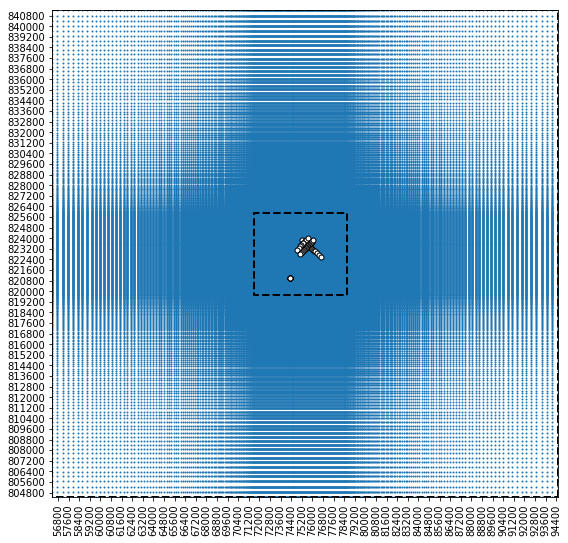

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(pts_df.X, pts_df.Y, s=1)
ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
ax.set(xlim=(mesh_bbox.left, mesh_bbox.right), ylim=(mesh_bbox.bottom, mesh_bbox.top), aspect='equal');
ax.add_patch(
    descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.add_patch(
    descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.set(aspect="equal")

ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(50))
ax.tick_params(rotation=90, axis='x')
fig.tight_layout();

# Smooth orography

In [15]:
with rio.open(dem_fname) as src:
    dem_resolution = max(*src.res)
    dem_data = src.read(1, masked=True)
    dem_transform = src.transform
    dem_extent = rio.plot.plotting_extent(dem_data, transform=src.transform)
assert dem_data.mask.sum() == 0
dem_resolution

25.0

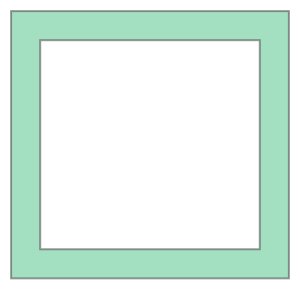

In [16]:
smoothing_distance = 4_000
smoothing_inner_boundary = sg.box(*mesh_bbox).buffer(-smoothing_distance)
smoothing_region = sg.box(*mesh_bbox).difference(smoothing_inner_boundary)
smoothing_region

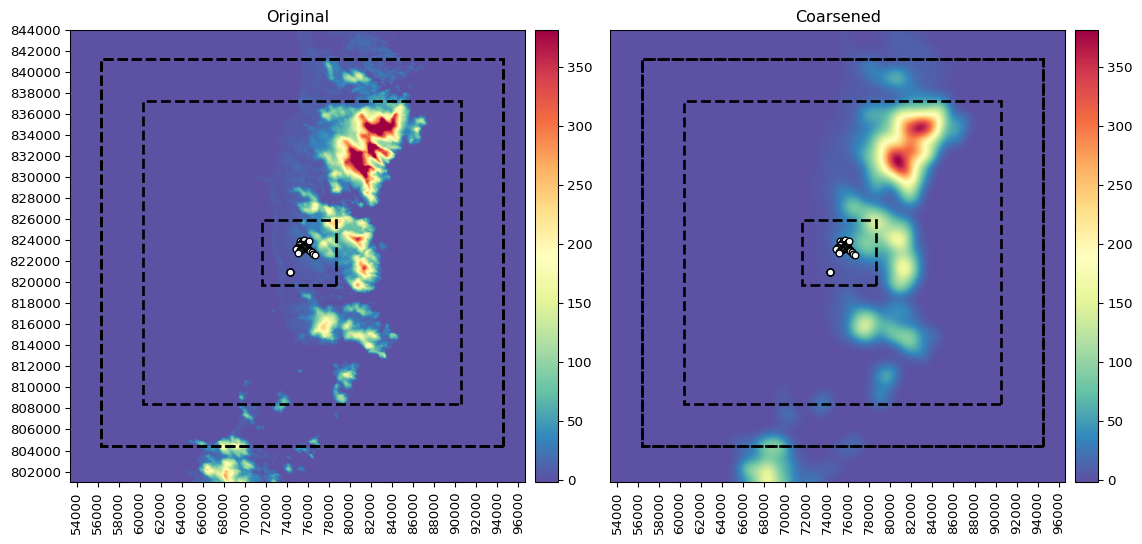

In [17]:
import scipy.ndimage
dem_coarsened = scipy.ndimage.gaussian_filter(dem_data, sigma=25, order=0)
vmin = min(dem_data.min(), dem_coarsened.min())
vmax = min(dem_data.max(), dem_coarsened.max())
fig, axL = plt.subplots(1, 2, figsize=(12, 6), dpi=96)
ims = []
ims.append(axL[0].imshow(dem_data, cmap='Spectral_r', extent=dem_extent, vmin=vmin, vmax=vmax))
ims.append(axL[1].imshow(dem_coarsened, cmap='Spectral_r', extent=dem_extent, vmin=vmin, vmax=vmax))
axL[0].set_title(f'Original')
axL[1].set_title(f'Coarsened')
for ax_i, ax in enumerate(axL):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cax.tick_params(rotation=90, axis='x', labelsize=8)
    plt.colorbar(ims[ax_i], orientation='vertical', cax=cax)        
    ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
    );     
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(25) if ax_i!=1 else plt.NullLocator())
    ax.tick_params(rotation=90, axis='x')
    ax.set(
        xlim=dem_extent[:2], 
        ylim=dem_extent[2:], 
        aspect='equal'
    );
fig.tight_layout();
import IPython
IPython.display.display(fig)
plt.close(fig);

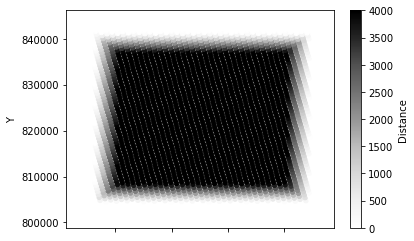

In [18]:
dem_h, dem_w = dem_data.shape
rows = [0] * dem_w
cols = range(dem_w)
rxs = rasterio.transform.xy(dem_transform, rows, cols, offset="center")[0]
rows = range(dem_h)
cols = [0] * dem_h
rys = rasterio.transform.xy(dem_transform, rows, cols, offset="center")[1][::-1]
dem_pts = pd.DataFrame(np.column_stack(
    [_.flatten() for _ in np.meshgrid(rxs, rys)] + \
    [_.flatten() for _ in np.meshgrid(range(dem_w), range(dem_h))]
), columns=['X', 'Y', 'I', 'J']).astype({'I': 'int', 'J': 'int'})
inner_box = rio.coords.BoundingBox(*smoothing_inner_boundary.bounds)
is_inside = dem_pts.X > inner_box.left
is_inside &= dem_pts.X < inner_box.right
is_inside &= dem_pts.Y > inner_box.bottom
is_inside &= dem_pts.Y < inner_box.top

is_inside1 = dem_pts.X < mesh_bbox.left
is_inside1 |= dem_pts.X > mesh_bbox.right
is_inside1 |= dem_pts.Y < mesh_bbox.bottom
is_inside1 |= dem_pts.Y > mesh_bbox.top
f = is_inside1 | is_inside
gs = gpd.GeoSeries(gpd.points_from_xy(dem_pts[~f].X, dem_pts[~f].Y))
dist = gs.distance(sg.box(*mesh_bbox).exterior)
dem_pts["Distance"] = 0
idx = dem_pts.index[~f]
dem_pts.loc[idx, "Distance"] = dist.values
idx = dem_pts.index[is_inside]
dem_pts.loc[idx, "Distance"] = smoothing_distance
idx = dem_pts.index[is_inside1]
dem_pts.loc[idx, "Distance"] = 0
dem_pts[::1000].plot.scatter(x='X', y='Y', c='Distance')

In [19]:
if 0:
    dem_pts["Z"] = dem_data[::-1].flatten()
    dem_pts[::250].plot.scatter(x='X', y='Y', c='Z', cmap='Spectral_r')
    plt.imshow(dem_pts["Z"].values.reshape(dem_h, dem_w)[::-1], extent=dem_extent)

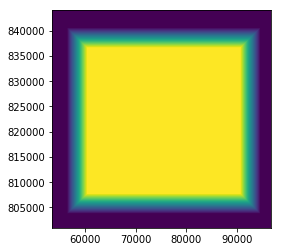

In [20]:
dem_pts["weights"]  = dem_pts['Distance'] / smoothing_distance
plt.imshow(dem_pts.weights.values.reshape(dem_h, dem_w), extent=dem_extent)

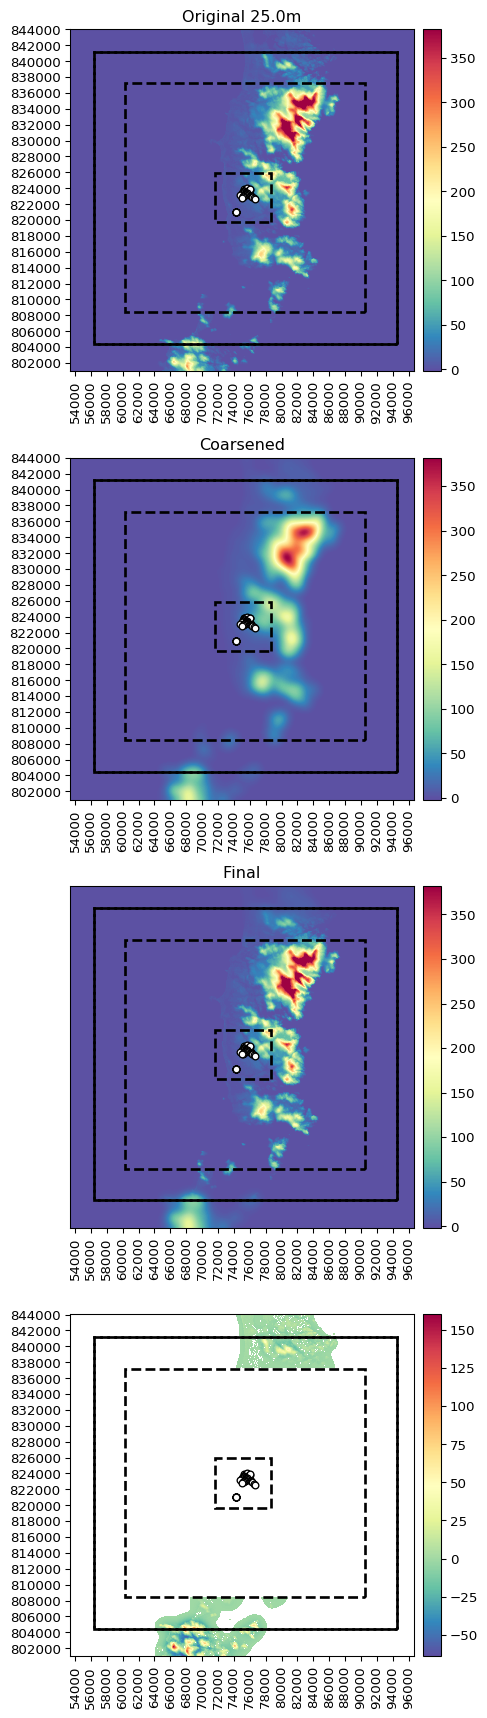

In [21]:
w = dem_pts.weights.values.reshape(dem_h, dem_w)[::-1]
smoothed_dem = dem_data * w + dem_coarsened * (1.0 - w)
vmin = min(dem_data.min(), dem_coarsened.min(), smoothed_dem.min())
vmax = min(dem_data.max(), dem_coarsened.max(), smoothed_dem.max())
fig, axL = plt.subplots(4, 1, figsize=(6, 18), dpi=96)
ims = []
ims.append(axL[0].imshow(dem_data, cmap='Spectral_r', extent=dem_extent, vmin=vmin, vmax=vmax))
ims.append(axL[1].imshow(dem_coarsened, cmap='Spectral_r', extent=dem_extent, vmin=vmin, vmax=vmax))
ims.append(axL[2].imshow(smoothed_dem, cmap='Spectral_r', extent=dem_extent, vmin=vmin, vmax=vmax))
ims.append(axL[3].imshow(
    np.ma.masked_equal(dem_data- smoothed_dem, 0), cmap='Spectral_r', extent=dem_extent)
)
axL[0].set_title(f'Original {dem_resolution}m')
axL[1].set_title(f'Coarsened')
axL[2].set_title(f'Final')
for ax_i, ax in enumerate(axL):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cax.tick_params(rotation=90, axis='x', labelsize=8)
    plt.colorbar(ims[ax_i], orientation='vertical', cax=cax)        
    ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
    );     
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(25) if ax_i!=2 else plt.NullLocator())
    ax.tick_params(rotation=90, axis='x')
    ax.set(
        xlim=dem_extent[:2], 
        ylim=dem_extent[2:], 
        aspect='equal'
    );
fig.tight_layout();
import IPython
IPython.display.display(fig)
plt.close(fig);



# Create interpolators

In [22]:
from mesher import create_bbox_interpolator
dem_interpolator_org = create_bbox_interpolator(dem_fname, mesh_bbox, resolution=resolution)
dem_interpolator = create_bbox_interpolator((smoothed_dem, dem_transform), mesh_bbox, resolution=resolution)
    
landcover_interpolator = create_bbox_interpolator(landcover_fname, mesh_bbox, resolution=resolution)

dem_interpolator_org, dem_interpolator, landcover_interpolator

(<scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f8d97d1c940>,
 <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f8d97d1c0b8>)

# Interpolate Elevation and landcover

In [23]:
pts_df['Z'] = dem_interpolator(pts_df[['X', 'Y']], method='linear')
assert pts_df.Z.isnull().sum() == 0

pts_df['ZOrg'] = dem_interpolator_org(pts_df[['X', 'Y']], method='linear')
assert pts_df.ZOrg.isnull().sum() == 0

pts_df['CLC'] = landcover_interpolator(pts_df[['X', 'Y']], method='nearest')
assert pts_df.CLC.isnull().sum() == 0

In [24]:
Delta_Z = pts_df['Z'].min() - pts_df['Z'].min().round(1)
Delta_Z

0.0

In [25]:
if 0:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    pts_df.plot.scatter(x='X', y='Y', c='Z', cmap='terrain', ax=ax)
    ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
    ax.set(xlim=(mesh_bbox.left, mesh_bbox.right), ylim=(mesh_bbox.bottom, mesh_bbox.top), aspect='equal');
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.set(aspect="equal")
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(25))
    ax.tick_params(rotation=90, axis='x')
    fig.tight_layout();
    
if 0:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    pts_df.plot.scatter(x='X', y='Y', c='CLC', cmap='terrain', ax=ax)
    ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
    ax.set(xlim=(mesh_bbox.left, mesh_bbox.right), ylim=(mesh_bbox.bottom, mesh_bbox.top), aspect='equal');
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.set(aspect="equal")
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(25))
    ax.tick_params(rotation=90, axis='x')
    fig.tight_layout();

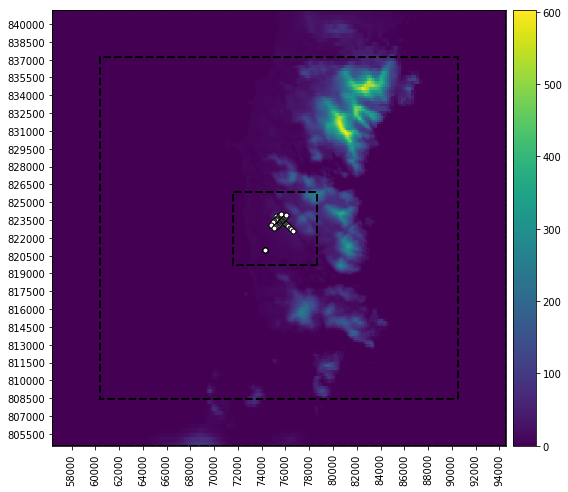

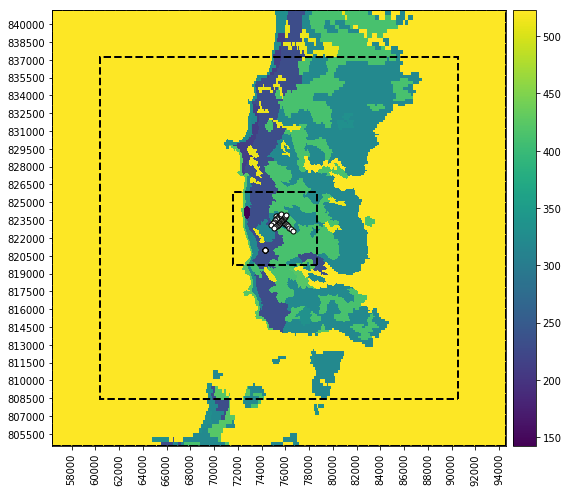

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.pcolormesh(
    xs, ys, pts_df.Z.values.reshape(ny+1, nx+1)
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, orientation='vertical', cax=cax)
ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
ax.set(xlim=(mesh_bbox.left, mesh_bbox.right), ylim=(mesh_bbox.bottom, mesh_bbox.top), aspect='equal');
ax.add_patch(
    descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.add_patch(
    descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.add_patch(
    descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.set(aspect="equal")
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
ax.yaxis.set_major_locator(plt.MaxNLocator(25))
ax.tick_params(rotation=90, axis='x')
fig.tight_layout();


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.pcolormesh(
    xs, ys, pts_df.CLC.values.reshape(ny+1, nx+1)
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, orientation='vertical', cax=cax)
ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
ax.set(xlim=(mesh_bbox.left, mesh_bbox.right), ylim=(mesh_bbox.bottom, mesh_bbox.top), aspect='equal');
ax.add_patch(
    descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.add_patch(
    descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.add_patch(
    descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
);
ax.set(aspect="equal")
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
ax.yaxis.set_major_locator(plt.MaxNLocator(25))
ax.tick_params(rotation=90, axis='x')
fig.tight_layout();

# Create vtk grid

In [27]:
import vtk
from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy

terrain_grid = vtk.vtkStructuredGrid()
terrain_grid.SetDimensions([xs.size, ys.size, 1])

vtk_pts = vtk.vtkPoints()
vtk_pts.SetData(numpy_to_vtk(pts_df[['X', 'Y', 'Z']].values, deep=True))
terrain_grid.SetPoints(vtk_pts)
if 0:
    lu_scalars = numpy_to_vtk(pts_df['CLC'].values, deep=True)
    lu_scalars.SetName("Landuse")
    terrain_grid.GetPointData().SetScalars(lu_scalars)

if 0:
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetFileName(str(SIM_PATH / "terrain_mesh.vts"))
    writer.SetInputData(terrain_grid)
    res = writer.Write()
    writer = None
    del writer
    
print(terrain_grid)

vtkStructuredGrid (0x55fb348a2670)
  Debug: Off
  Modified Time: 716
  Reference Count: 1
  Registered Events: (none)
  Information: 0x55fb1b2a2c20
  Data Released: False
  Global Release Data: Off
  UpdateTime: 0
  Field Data:
    Debug: Off
    Modified Time: 67
    Reference Count: 1
    Registered Events: (none)
    Number Of Arrays: 0
    Number Of Components: 0
    Number Of Tuples: 0
  Number Of Points: 238326
  Number Of Cells: 237350
  Cell Data:
    Debug: Off
    Modified Time: 70
    Reference Count: 1
    Registered Events: 
      Registered Observers:
        vtkObserver (0x55fb34330560)
          Event: 33
          EventName: ModifiedEvent
          Command: 0x55fb1b275a00
          Priority: 0
          Tag: 1
    Number Of Arrays: 0
    Number Of Components: 0
    Number Of Tuples: 0
    Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
    Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
    Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
    Scalars: (none)
    Vectors: (none)
    Normals: (none

/usr/local/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


# Extract cell centers

In [28]:
ccs_extractor = vtk.vtkCellCenters()
ccs_extractor.SetInputData(terrain_grid)
ccs_extractor.Update()
cc = vtk_to_numpy(ccs_extractor.GetOutput().GetPoints().GetData())
ccs_extractor = None
del ccs_extractor
cc = cc.reshape(ny, nx, 3, order = 'C')
ccs_df = pd.DataFrame(cc.reshape(nx*ny, 3), columns=['X', 'Y', 'Z'])
ccs_df['Z1'] = dem_interpolator(ccs_df[['X', 'Y']], method='linear')
assert ccs_df.Z1.isnull().sum() == 0
ccs_df['CLC_Nearest'] = landcover_interpolator(ccs_df[['X', 'Y']], method='nearest')
assert ccs_df.CLC_Nearest.isnull().sum() == 0

In [29]:
ccs_df['Z'].min()

-1.0

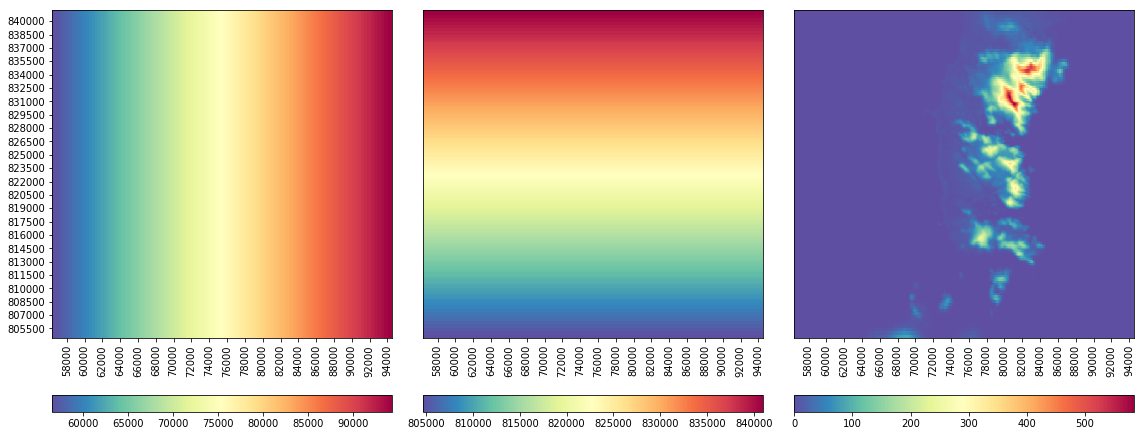

In [30]:
if 1:
    fig, (axx, axy, axz) = plt.subplots(1, 3, figsize=(16, 8))
    ims = []
    ims.append(axx.pcolormesh(xs, ys, cc[:, :, 0], cmap='Spectral_r'))
    ims.append(axy.pcolormesh(xs, ys, cc[:, :, 1], cmap='Spectral_r'))
    ims.append(axz.pcolormesh(xs, ys, cc[:, :, 2], cmap='Spectral_r'))
    for i, ax in enumerate((axx, axy, axz)):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.8)
        plt.colorbar(ims[i], orientation='horizontal', cax=cax)
        ax.set(aspect="equal")
        ax.xaxis.set_major_locator(plt.MaxNLocator(25))
        ax.yaxis.set_major_locator(plt.MaxNLocator(25) if i == 0 else plt.NullLocator())
        ax.tick_params(rotation=90, axis='x')
    fig.tight_layout();

    

# Get area weighted landocover

In [31]:
with rio.open(landcover_fname) as src:
    if resolution is None:
        resolution = max(*src.res)            
    win = rio.windows.from_bounds(
        mesh_bbox.left - 1 * max(resolution, src.res[0]),
        mesh_bbox.bottom - 1 * max(resolution, src.res[1]),
        mesh_bbox.right + 1 * max(resolution, src.res[0]),
        mesh_bbox.top + 1 * max(resolution, src.res[1]),
        transform=src.transform,
        height=None,
        width=None,
        precision=None,
    )
    transform = rio.windows.transform(win, src.transform)  
    clc_data = src.read(1, masked=True, window=win).filled(0)
    extent = rio.plot.plotting_extent(clc_data, transform=transform)
    del transform

from mesher import generate_lancover_luts
landcover_luts, landcover_data = generate_lancover_luts(clc_data)
print(landcover_data.keys())
print(landcover_luts.keys())

dict_keys(['CLC', 'AGL', 'Z0L', 'EPSGL', 'FWL', 'ALAMBDAL', 'ALAMBDAT'])
dict_keys(['AGL', 'Z0L', 'EPSGL', 'FWL', 'ALAMBDAL', 'ALAMBDAT'])


In [32]:
num_workers = 18
from collections import defaultdict
y_indices = defaultdict(list)
yi = 0
while yi < ny:
    for worker_i in range(num_workers):
        if yi < ny:
            y_indices[worker_i].append(yi)
        yi += 1           
assert sum(len(v) for v in y_indices.values()) == ny
{k: len(v) for k, v in y_indices.items()}

{0: 27,
 1: 27,
 2: 26,
 3: 26,
 4: 26,
 5: 26,
 6: 26,
 7: 26,
 8: 26,
 9: 26,
 10: 26,
 11: 26,
 12: 26,
 13: 26,
 14: 26,
 15: 26,
 16: 26,
 17: 26}

In [33]:
import dask.bag
from mesher import interpolate_landcover
bag = dask.bag.from_sequence(tuple(y_indices.values())).map(
    lambda y_indices: interpolate_landcover(
        landcover_fname, 
        xs, ys, 
        landcover_luts, 
        y_indices=y_indices, 
        resolution=resolution
    )
)
land_cover_res_ys = bag.compute(scheduler='processes', num_workers=num_workers) 
land_cover_res = np.empty((nx, ny, len(landcover_luts) + 1))
for vals_list in land_cover_res_ys:
    for yi, vals in vals_list:    
        land_cover_res[:, yi, :] = np.copy(vals)
del land_cover_res_ys
land_cover_res.shape  

INFO:mesher:Starting processing 27
INFO:mesher:    1 / 27
INFO:mesher:Starting processing 27
INFO:mesher:    1 / 27
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:Starting processing 26
INFO:mesher:    1 / 26
INFO:mesher:    1 / 26
INFO:mesher:    1 / 26
INFO:mesher:    1 / 26
INFO:mesher:    1 / 26
INFO:mesher:    1 / 26
IN

INFO:mesher:    18 / 26
INFO:mesher:    16 / 26
INFO:mesher:    21 / 26
INFO:mesher:    20 / 26
INFO:mesher:    19 / 26
INFO:mesher:    18 / 26
INFO:mesher:    19 / 26
INFO:mesher:    17 / 26
INFO:mesher:    20 / 26
INFO:mesher:    20 / 26
INFO:mesher:    19 / 26
INFO:mesher:    21 / 26
INFO:mesher:    19 / 27
INFO:mesher:    19 / 26
INFO:mesher:    19 / 26
INFO:mesher:    15 / 27
INFO:mesher:    18 / 26
INFO:mesher:    21 / 26
INFO:mesher:    22 / 26
INFO:mesher:    17 / 26
INFO:mesher:    20 / 26
INFO:mesher:    21 / 26
INFO:mesher:    19 / 26
INFO:mesher:    22 / 26
INFO:mesher:    21 / 26
INFO:mesher:    18 / 26
INFO:mesher:    19 / 26
INFO:mesher:    20 / 26
INFO:mesher:    20 / 26
INFO:mesher:    20 / 26
INFO:mesher:    20 / 27
INFO:mesher:    20 / 26
INFO:mesher:    22 / 26
INFO:mesher:    16 / 27
INFO:mesher:    19 / 26
INFO:mesher:    22 / 26
INFO:mesher:    18 / 26
INFO:mesher:    21 / 26
INFO:mesher:    22 / 26
INFO:mesher:    20 / 26
INFO:mesher:    20 / 26
INFO:mesher:    

(505, 470, 7)

In [34]:
for dim_i, array_name in enumerate(landcover_data.keys()):    
    if array_name == 'CLC':
        array_name = 'CLC_AreaWeighted'       
    if array_name == 'ALAMBDAT':
        array_name = 'RHOB'   
    elif array_name == 'ALAMBDAL':
        array_name = 'ALAMBDA'   
    elif array_name == 'Z0L':
        array_name = 'Z0'   
    elif array_name == 'FWL':
        array_name = 'FW' 
    elif array_name == 'EPSGL':
        array_name = 'EPSG'
    elif array_name == 'AGL':
        array_name = 'ALBEDO'
    ccs_df[array_name] = np.transpose(land_cover_res[:, :, dim_i], [1, 0]).ravel()    
    vtk_arr = numpy_to_vtk(ccs_df[array_name].values, deep=True)
    vtk_arr.SetName(array_name)
    terrain_grid.GetCellData().AddArray(vtk_arr)

'''
RHOB[I, J] = RHOB[I, J] + ALAMBDAT[NR] * (float)LUSPROZ[I][J][NR] * TERMPROZ;
ALAMBDA[I, J] = ALAMBDA[I, J] + ALAMBDAL[NR] * (float)LUSPROZ[I][J][NR] * TERMPROZ;
Z0[I, J] = Z0[I, J] + Z0L[NR] * (float)LUSPROZ[I][J][NR] * TERMPROZ;
FW[I, J] = FW[I, J] + FWL[NR] * (float)LUSPROZ[I][J][NR] * TERMPROZ;
EPSG[I, J] = EPSG[I, J] + EPSGL[NR] * (float)LUSPROZ[I][J][NR] * TERMPROZ;
ALBEDO[I, J] = ALBEDO[I, J] + AGL[NR] * (float)LUSPROZ[I][J][NR] * TERMPROZ;
soil heat capacity
RHOB[I, J] = ALAMBDAT[0];
ALAMBDA[I, J] = ALAMBDAL[0];
RHOB[I, J] = ALAMBDA[I, J] / RHOB[I, J] / CPBOD;
'''
CPBOD = 900;
ccs_df["RHOB"] = ccs_df["ALAMBDA"] / ccs_df["RHOB"] / CPBOD;
vtk_arr = numpy_to_vtk(ccs_df['RHOB'].values, deep=True)
vtk_arr.SetName('RHOB')
terrain_grid.GetCellData().AddArray(vtk_arr)

vtk_arr = numpy_to_vtk(ccs_df['Z'].values, deep=True)
vtk_arr.SetName('Z')
terrain_grid.GetCellData().AddArray(vtk_arr)


vtk_arr = numpy_to_vtk(ccs_df['Z1'].values, deep=True)
vtk_arr.SetName('Z_linear_interpolation')
terrain_grid.GetCellData().AddArray(vtk_arr)


vtk_arr = numpy_to_vtk(pts_df['Z'].values, deep=True)
vtk_arr.SetName('Z')
terrain_grid.GetPointData().AddArray(vtk_arr)

vtk_arr = numpy_to_vtk(pts_df['ZOrg'].values, deep=True)
vtk_arr.SetName('ZOrg')
terrain_grid.GetPointData().AddArray(vtk_arr)
    
    
ccs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,237350.0,75170.296875,6231.409668,56552.972656,71987.500000,75137.500000,78287.500000,94337.445312
Y,237350.0,822185.562500,6096.886230,804653.000000,819862.500000,822800.000000,825737.500000,840996.062500
Z,237350.0,22.629614,46.987343,-1.000000,0.000000,3.812500,18.062500,585.163940
Z1,237350.0,22.631648,47.149764,-2.000000,0.000000,4.000000,18.000000,597.688033
CLC_Nearest,237350.0,424.183851,107.377542,142.000000,322.000000,412.000000,523.000000,523.000000
CLC_AreaWeighted,237350.0,424.262886,107.362831,142.000000,322.000000,412.000000,523.000000,523.000000
ALBEDO,237350.0,0.120666,0.040360,0.080000,0.081000,0.140000,0.150000,0.250000
Z0,237350.0,0.019445,0.035286,0.000100,0.000100,0.010000,0.020000,0.300000
EPSG,237350.0,0.954828,0.025930,0.920000,0.920000,0.950000,0.980000,0.980000
FW,237350.0,0.653763,0.387799,0.010000,0.100000,0.700000,1.000000,1.000000


In [35]:
writer = vtk.vtkXMLStructuredGridWriter()
writer.SetFileName(str(SIM_PATH / "terrain_grid.vts"))
writer.SetInputData(terrain_grid)
res = writer.Write()
writer = None
del writer

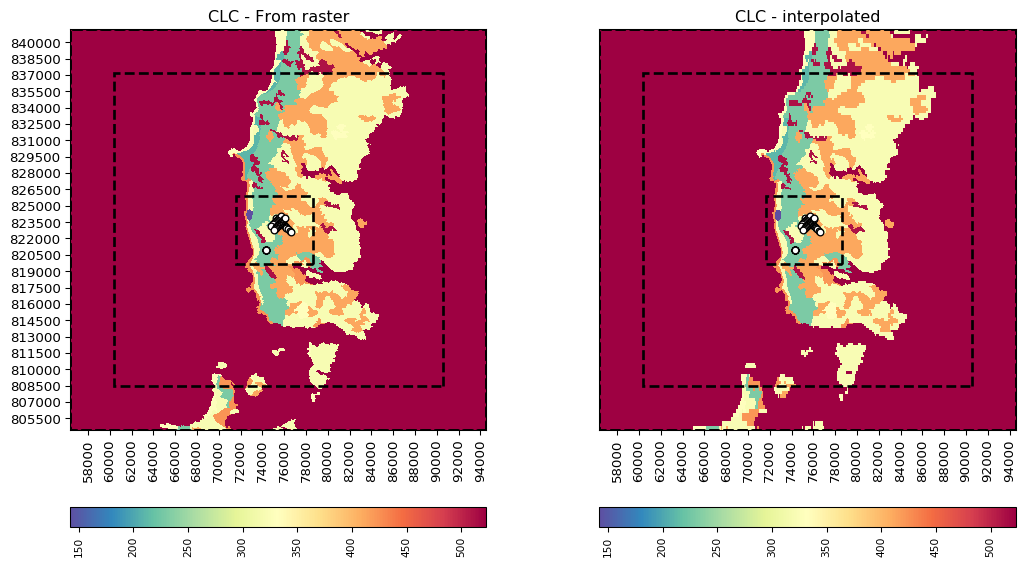

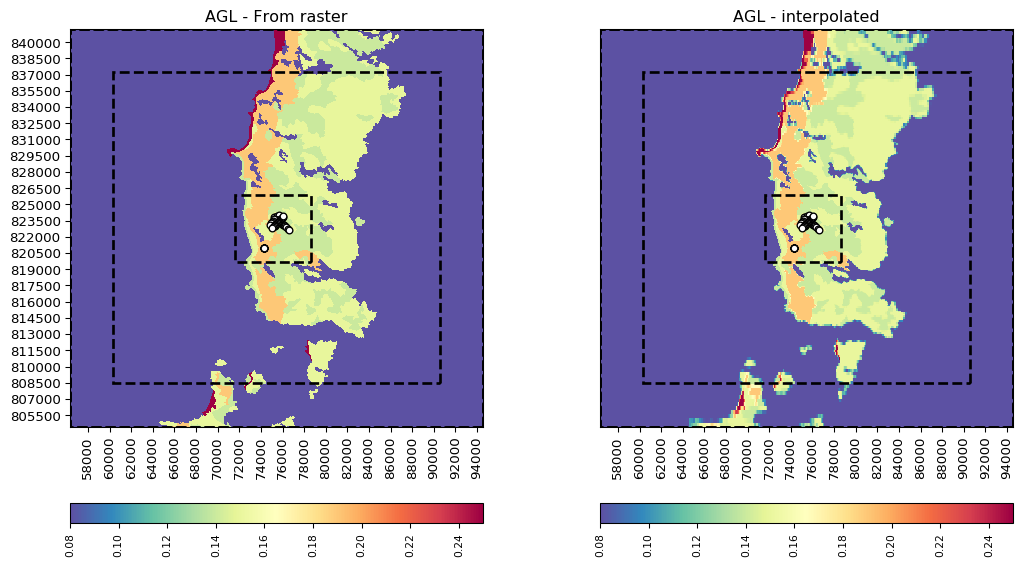

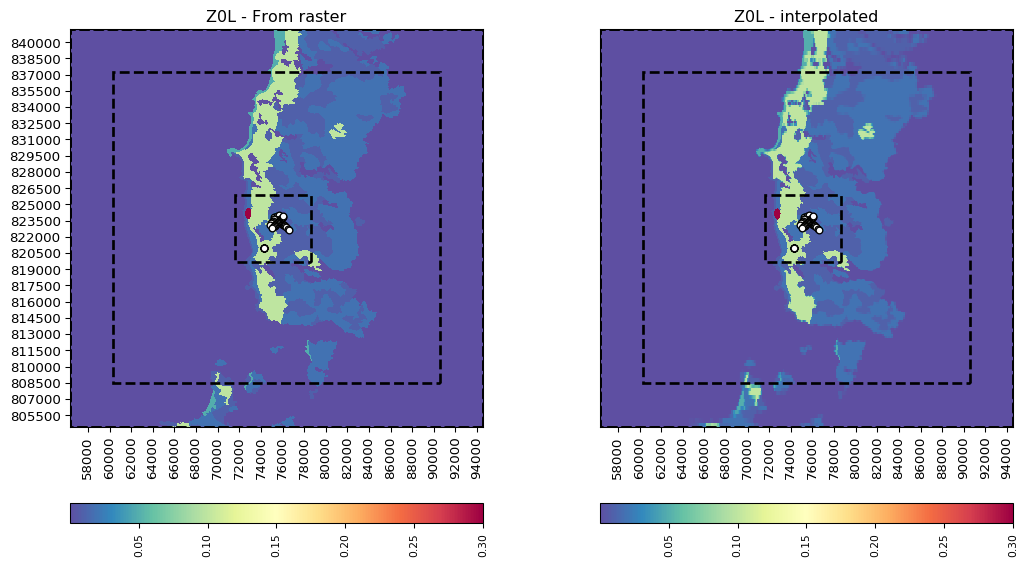

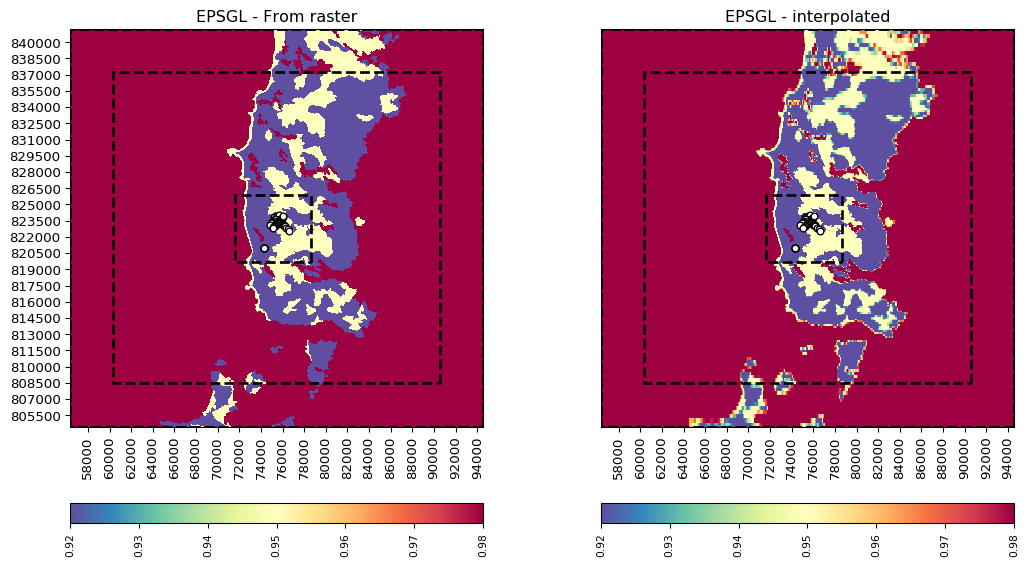

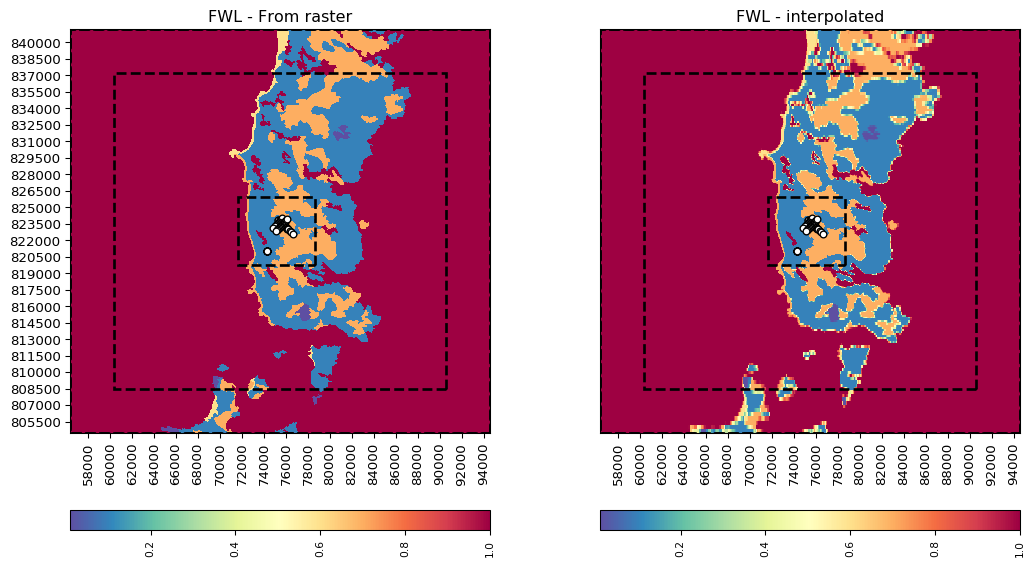

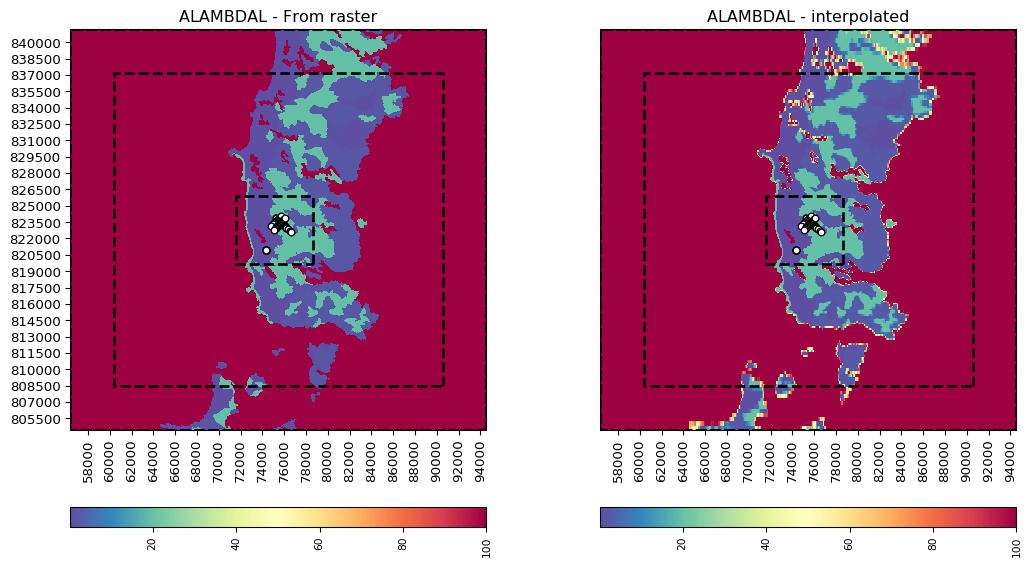

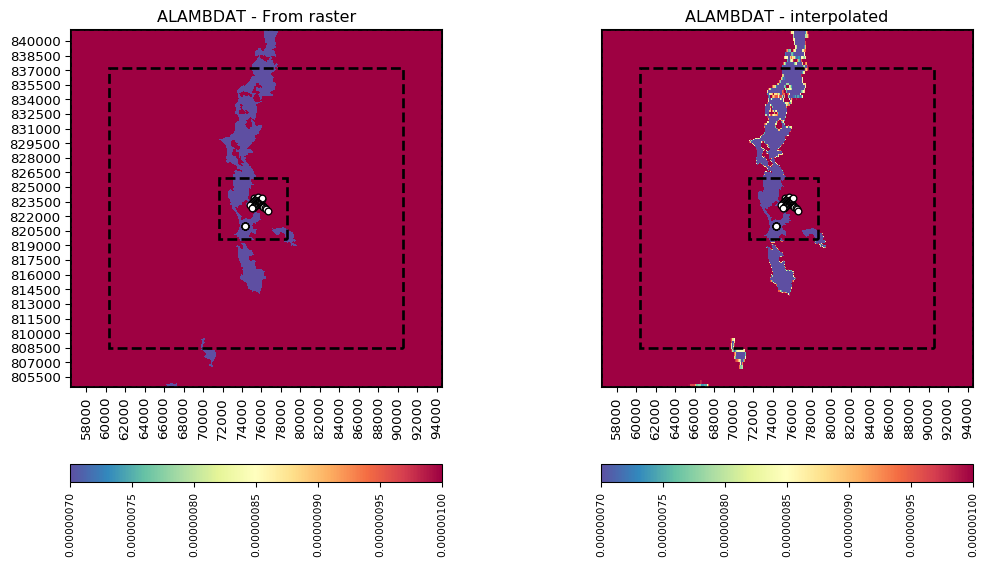

In [36]:
for dim_i, (array_name, landcover_raster) in enumerate(landcover_data.items()):    
    fig, axL = plt.subplots(1, 2, figsize=(12, 6), dpi=96)
    ims = []
    ims.append(axL[0].imshow(landcover_raster, cmap='Spectral_r', extent=extent))
    ims.append(axL[1].pcolormesh(xs, ys, land_cover_res[:, :, dim_i].T, cmap='Spectral_r'))
    axL[0].set_title(f'{array_name} - From raster')
    axL[1].set_title(f'{array_name} - interpolated')
    for ax_i, ax in enumerate(axL):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.8)
        cax.tick_params(rotation=90, axis='x', labelsize=8)
        plt.colorbar(ims[ax_i], orientation='horizontal', cax=cax)        
        ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
        ax.add_patch(
            descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
        );
        ax.add_patch(
            descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
        );
        ax.add_patch(
            descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
        );
        ax.xaxis.set_major_locator(plt.MaxNLocator(25))
        ax.yaxis.set_major_locator(plt.MaxNLocator(25) if ax_i ==0 else plt.NullLocator())
        ax.tick_params(rotation=90, axis='x')
        ax.set(
            xlim=(mesh_bbox.left, mesh_bbox.right), 
            ylim=(mesh_bbox.bottom, mesh_bbox.top), 
            aspect='equal'
        );
    fig.tight_layout();
    import IPython
    IPython.display.display(fig)
    plt.close(fig);



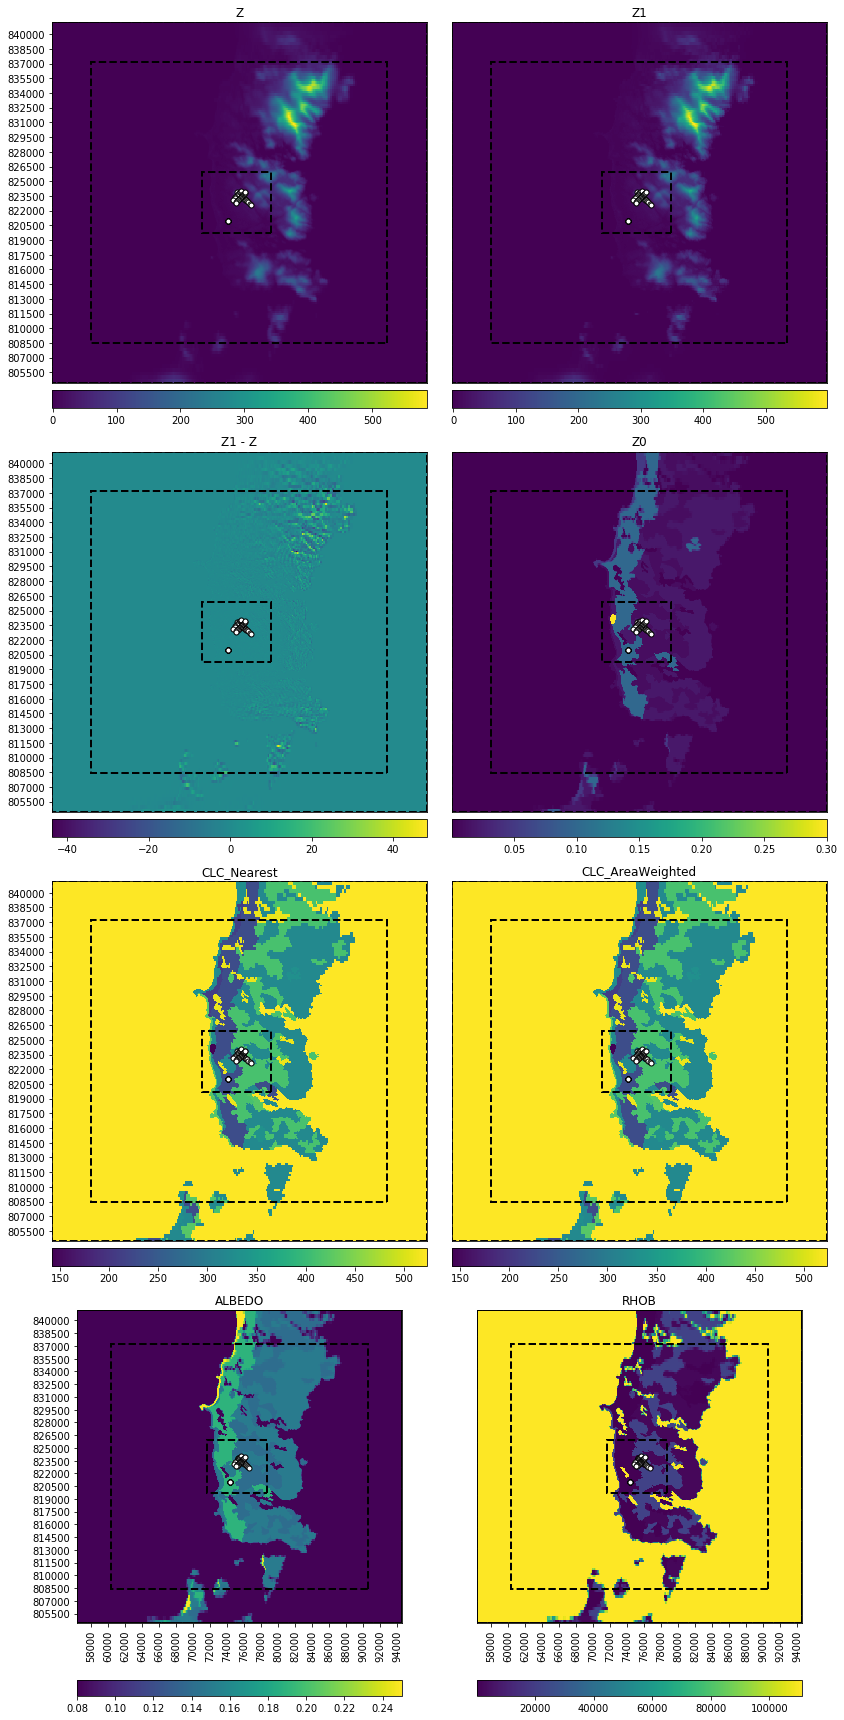

In [37]:
fig, axL = plt.subplots(4, 2, figsize=(12, 4*6))
ims = []
ims.append(axL[0, 0].pcolormesh(xs, ys, ccs_df.Z.values.reshape(ny, nx)))
ims.append(axL[0, 1].pcolormesh(xs, ys, ccs_df.Z1.values.reshape(ny, nx)))
ims.append(axL[1, 0].pcolormesh(xs, ys, (ccs_df.Z1 - ccs_df.Z).values.reshape(ny, nx)))
ims.append(axL[1, 1].pcolormesh(xs, ys, ccs_df.Z0.values.reshape(ny, nx)))
ims.append(axL[2, 0].pcolormesh(xs, ys, ccs_df.CLC_Nearest.values.reshape(ny, nx)))
ims.append(axL[2, 1].pcolormesh(xs, ys, ccs_df.CLC_AreaWeighted.values.reshape(ny, nx)))
ims.append(axL[3, 0].pcolormesh(xs, ys, ccs_df.ALBEDO.values.reshape(ny, nx)))
ims.append(axL[3, 1].pcolormesh(xs, ys, ccs_df.RHOB.values.reshape(ny, nx)))
axL[0, 0].set_title("Z")
axL[0, 1].set_title("Z1")
axL[1, 0].set_title("Z1 - Z")
axL[1, 1].set_title("Z0")
axL[2, 0].set_title("CLC_Nearest")
axL[2, 1].set_title("CLC_AreaWeighted")
axL[3, 0].set_title("ALBEDO")
axL[3, 1].set_title("RHOB")

cpt = 0
for (i, j), ax in np.ndenumerate(axL):
    ax.plot(
        locs_gdf.GridRefX, locs_gdf.GridRefY, 
        zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white'
    )
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.xaxis.set_major_locator(plt.MaxNLocator(25) if i == 3 else plt.NullLocator())
    ax.yaxis.set_major_locator(plt.MaxNLocator(25) if j == 0 else plt.NullLocator())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1 if i != 3 else 0.8)
    plt.colorbar(ims[cpt], orientation='horizontal', cax=cax)
    ax.tick_params(rotation=90, axis='x')
    ax.set(
        xlim=(mesh_bbox.left, mesh_bbox.right), 
        ylim=(mesh_bbox.bottom, mesh_bbox.top), aspect='equal'
    );
    cpt += 1
    
fig.tight_layout();

# Write ggeom

In [38]:
from mesher import GrammMesher
print(nx, ny, nz, dz0, ddz, pts_df['Z'].min(), pts_df['Z'].max())

grammMesh = GrammMesher.create_mesh(
    nx, ny, nz, 
    pts_df, ccs_df, 
    xs, ys, dist_x, dist_y, mesh_bbox, dz0, ddz, 
    n_constant_cells=n_constant_cells
)


print(grammMesh.nx*grammMesh.ny)
print(grammMesh.nx*grammMesh.ny*grammMesh.nz)
print(pd.Series(grammMesh.Z).round(1))
print(pd.Series(grammMesh.Z-grammMesh.Z.min()).round(1))
if 1:
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetFileName(str(SIM_PATH / "ggeom.vts"))
    writer.SetInputData(grammMesh.grid)
    res = writer.Write()
    writer = None
    del writer
    "OK"
if 1:
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetFileName(str(SIM_PATH / "ggeom_terrain.vts"))
    writer.SetInputData(grammMesh.terrain_grid)
    res = writer.Write()
    writer = None
    del writer
    "OK"
nx, ny, nz   

INFO:mesher:1810.5039407178979


505 470 35 4.0 1.14 -1.0 602.5013135726326
237350
8307250
0       -1.0
1        3.0
2        7.0
3       11.0
4       15.0
5       19.6
6       24.8
7       30.7
8       37.4
9       45.1
10      53.9
11      63.9
12      75.3
13      88.3
14     103.2
15     120.1
16     139.4
17     161.3
18     186.4
19     214.9
20     247.5
21     284.6
22     326.9
23     375.1
24     430.1
25     492.7
26     564.2
27     645.6
28     738.5
29     844.3
30     965.0
31    1102.6
32    1259.4
33    1438.1
34    1641.9
35    1874.3
dtype: float64
0        0.0
1        4.0
2        8.0
3       12.0
4       16.0
5       20.6
6       25.8
7       31.7
8       38.4
9       46.1
10      54.9
11      64.9
12      76.3
13      89.3
14     104.2
15     121.1
16     140.4
17     162.3
18     187.4
19     215.9
20     248.5
21     285.6
22     327.9
23     376.1
24     431.1
25     493.7
26     565.2
27     646.6
28     739.5
29     845.3
30     966.0
31    1103.6
32    1260.4
33    1439.1
34    1642.9
35  

(505, 470, 35)

In [39]:
EXPORT_PATH = SIM_PATH / 'Computation'
EXPORT_PATH.is_dir()

print(f'Mesh size: {nx*ny*nz/1e3:.2f}K cells')
geb = grammMesh.generate_geb()
print(geb)

EXPORT_PATH.joinpath('GRAMM.geb').write_text(geb);
grammMesh.write_landuse(EXPORT_PATH / 'landuse.asc')
grammMesh.write_ggeom_binary(EXPORT_PATH / 'ggeom.asc', angle=0.0)

Mesh size: 8307.25K cells
505                 !Number of cells in x-direction
470                 !Number of cells in y-direction
35                  !Mumber of cells in z-direction
56350.0             !West border of GRAMM model domain [m]
94550.0             !East border of GRAMM model domain [m]
804450.0            !South border of GRAMM model domain [m]
841200.0            !North border of GRAMM model domain [m]


PosixPath('/home/ewsuser/ews_drives/s_EWSProjects/GralDispersionModel/ValidationCases/Askervein/01_simulation_resolution_25m/Computation/ggeom.asc')

In [40]:
from_py = GrammMesher.read_mesh(EXPORT_PATH / 'ggeom.asc')
from_py.read_landuse(EXPORT_PATH / 'landuse.asc')
from_py.xmin, from_py.xmax, from_py.ymin, from_py.ymax

(56350, 94550.0, 804450, 841200.0)

In [41]:
1/0

ZeroDivisionError: division by zero

INFO:root:RHOB


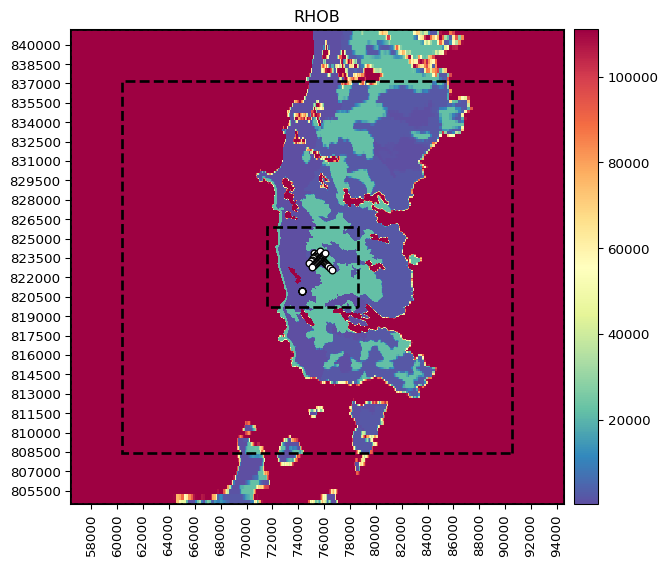

INFO:root:ALAMBDA


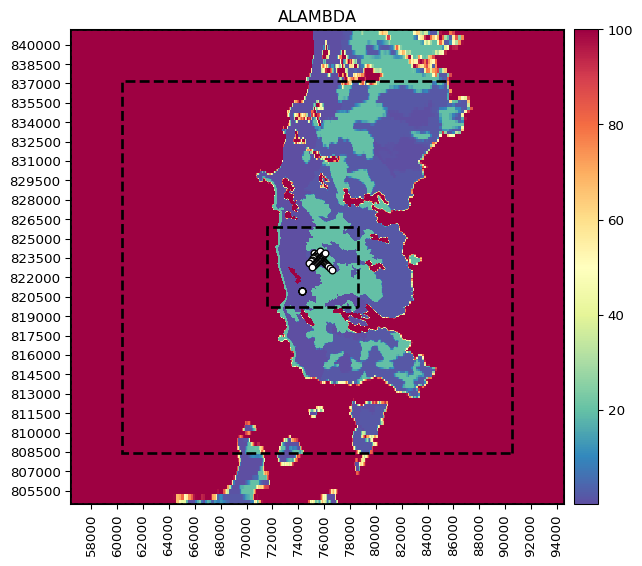

INFO:root:Z0


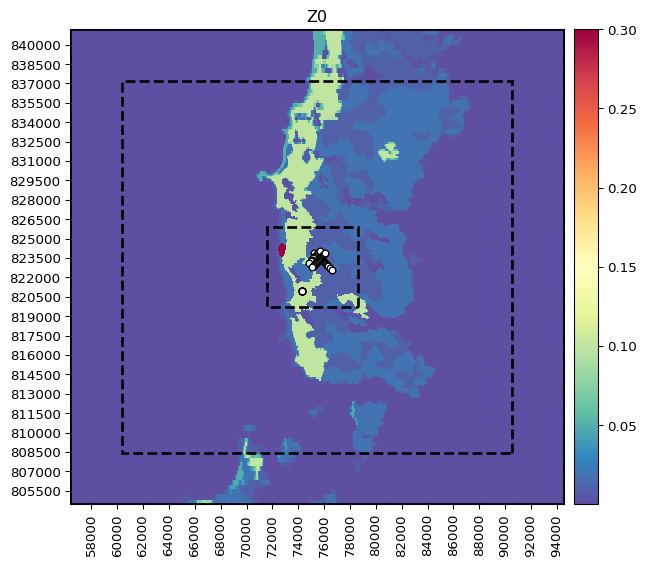

INFO:root:FW


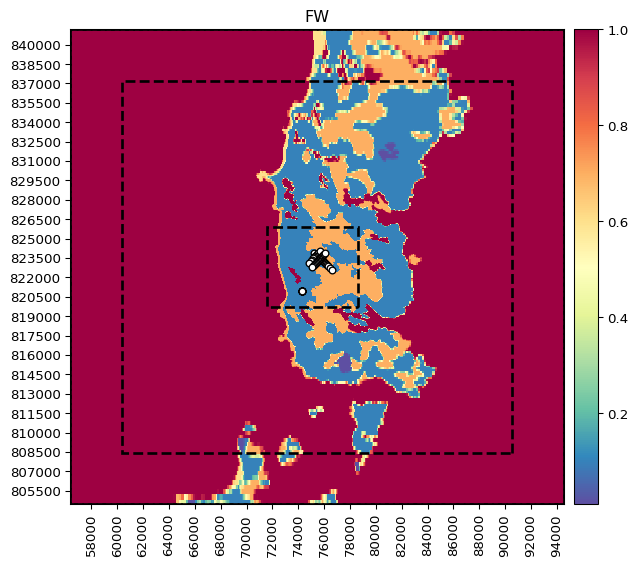

INFO:root:EPSG


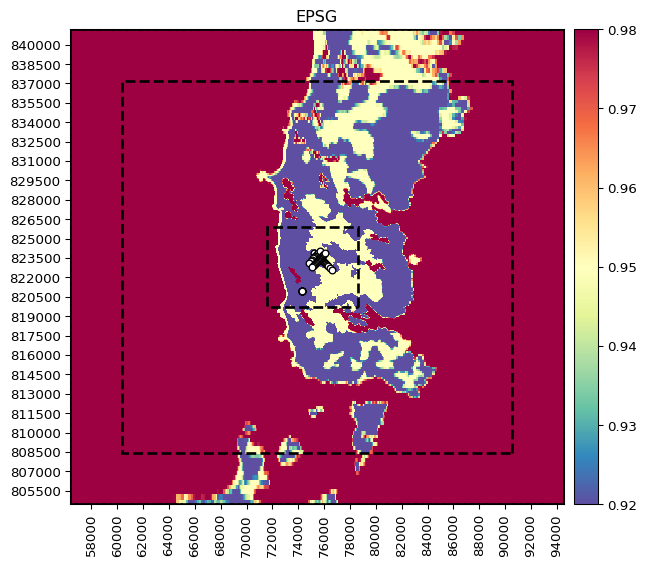

INFO:root:ALBEDO


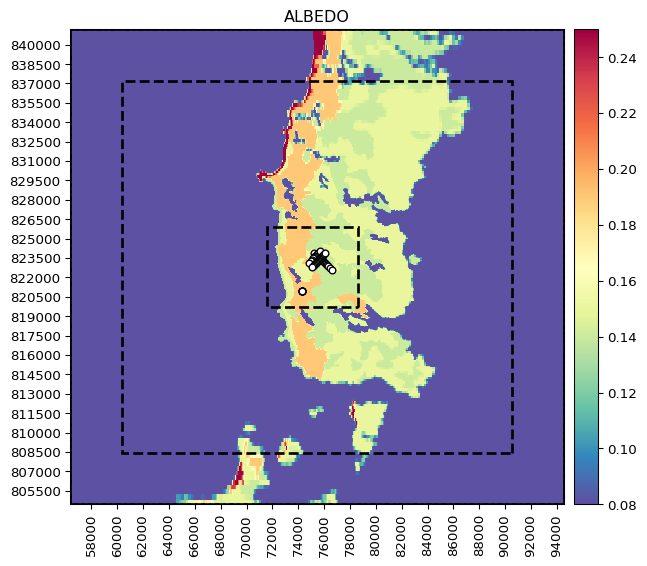

INFO:root:CLC


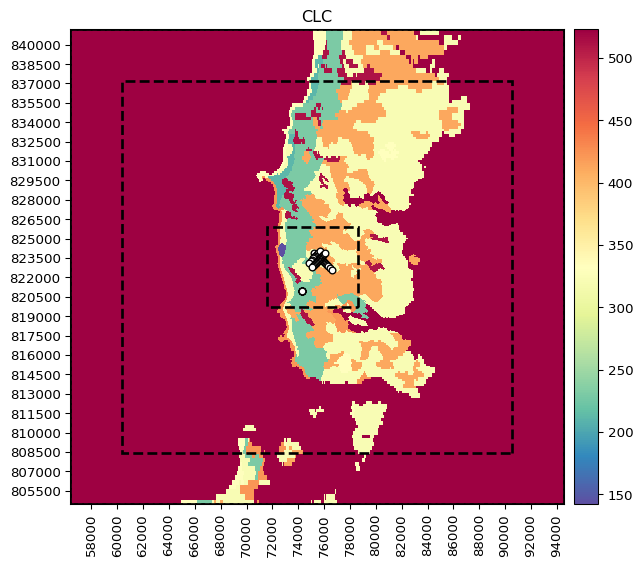

In [42]:
for arr_i in range(from_py.terrain_grid.GetCellData().GetNumberOfArrays()):
    vtk_arr = from_py.terrain_grid.GetCellData().GetArray(arr_i)
    arr = vtk_to_numpy(vtk_arr).reshape(from_py.nx, from_py.ny, order='F')
    logging.info(vtk_arr.GetName())
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=96)
    im = ax.pcolormesh(
        from_py.xmin + from_py.X, 
        from_py.ymin + from_py.Y, 
        arr.T, 
        cmap='Spectral_r'
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cax.tick_params(rotation=90, axis='x', labelsize=8)
    plt.colorbar(im, orientation='vertical', cax=cax)        
    ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*mesh_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(sg.box(*ref_bbox), fc='none', ec='k', lw=2, zorder=100, ls='--')
    );
    ax.add_patch(
        descartes.patch.PolygonPatch(smoothing_region, fc='none', ec='k', lw=2, zorder=100, ls='--')
    );     
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(25))
    ax.tick_params(rotation=90, axis='x')
    ax.set(
        xlim=(from_py.xmin, from_py.xmax), 
        ylim=(from_py.ymin, from_py.ymax),  
        aspect='equal',
        title=vtk_arr.GetName()
    );
    fig.tight_layout();
    import IPython
    IPython.display.display(fig)
    plt.close(fig);
    del arr, vtk_arr
    import gc
    gc.collect()


In [43]:
writer = vtk.vtkXMLStructuredGridWriter()
writer.SetFileName(str(EXPORT_PATH / "grid.vts"))
writer.SetInputData(from_py.grid)
res = writer.Write()
writer = None
del writer

writer = vtk.vtkXMLStructuredGridWriter()
writer.SetFileName(str(EXPORT_PATH / "terrain_grid.vts"))
writer.SetInputData(from_py.terrain_grid)
res = writer.Write()
writer = None
del writer
"OK"

'OK'

In [46]:
def get_nb_url(port=None):
    import notebook
    import notebook.notebookapp
    import re
    import json
    import logging
    
    nb_server = next(notebook.notebookapp.list_running_servers())
    
    if port is None:        
        port = int(nb_server['port'])
        
    kernel_id = None
    try:
        kernel_id = re.search("kernel-(.*).json", get_ipython().config["IPKernelApp"]["connection_file"]).group(1)
    except NameError:
        import ipykernel

        kernel_id = re.search("kernel-(.*).json", ipykernel.connect.get_connection_file()).group(1)
    logging.debug(f"kernel_id: {kernel_id!r}")
    response = requests.get("http://127.0.0.1:{port}/api/sessions".format(port=port))

    matching = [s for s in json.loads(response.text) if s["kernel"]["id"] == kernel_id]
    if matching:
        return nb_server['url'] + 'notebook/' + matching[0]["notebook"]["path"]
    return ""

def convert_notebook(nb_url, fname=None, fmt="html", notebook_dir=None):
    import pathlib
    import urllib
    import logging
    if notebook_dir is None:
        import notebook
        import notebook.notebookapp
        nb_server = next(notebook.notebookapp.list_running_servers())
        notebook_dir = nb_server['notebook_dir']
        
    notebook_dir = pathlib.Path(notebook_dir)
    parts = notebook_dir.parts
        
    url = nb_url.split("/")
    
    print(parts)
    print(url)
    url[3] = f"nbconvert/{fmt}"
    resp = requests.get("/".join(url) + "?download=false")
    if resp.status_code != 200:
        print(resp)
        return None
    
    nb_fname = list(parts) + url[4:]
    print(nb_fname)
    nb_fname = pathlib.Path('/'.join(nb_fname))
    assert nb_fname.is_file()
    ext = None
    ctype = resp.headers["Content-Type"]
    content = resp.content
    logging.debug(resp.headers["Content-Type"])
    if "text/x-python" in ctype:
        ext = ".py"
    elif "text/html" in ctype:
        ext = ".html"
    elif "application/json" in ctype:
        ext = ".ipynb"
    elif "application/zip" in ctype:
        ext = ".zip"
        nb_name = nb_fname.stem + (".html" if fmt != "markdown" else ".md")
        with zipfile.ZipFile(io.BytesIO(content), mode="r") as fin:
            # print(fin.filelist)
            content = fin.open(nb_name).read()
    else:
        pass
    if fmt == "script":
        ext = ".py"
    if fmt == "ipynb":
        ext = ".ipynb"
    if fmt == "markdown":
        ext = ".md"

    if not isinstance(fname, (str, pathlib.Path)):
        default_fname = nb_fname.parent / (nb_fname.stem + ext)
        assert default_fname != nb_fname, "cannot overwrite notebook"
        fname = default_fname
    if fname.is_file():
        logging.debug(f"Deleting {str(fname)!r}")
        try:
            fname.unlink()
        except OSError:
            pass
    logging.debug(fname)
    fname.write_bytes(content)
    return fname


convert_notebook(get_nb_url())

('/', 'home', 'ewsuser')
['http:', '', '0.0.0.0:8891', 'notebook', 'ews_drives', 's_EWSProjects', 'GralDispersionModel', 'ValidationCases', 'Askervein', 'manual_meshing_resolution_25m.ipynb']
['/', 'home', 'ewsuser', 'ews_drives', 's_EWSProjects', 'GralDispersionModel', 'ValidationCases', 'Askervein', 'manual_meshing_resolution_25m.ipynb']


PosixPath('//home/ewsuser/ews_drives/s_EWSProjects/GralDispersionModel/ValidationCases/Askervein/manual_meshing_resolution_25m.html')